In [ ]:
## 1. 우선 런타임에서 TPU 선택

In [ ]:
## 2. TPU 초기화
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
## 3. TPU strategy 셋팅

# tf.distribute.Strategy는 훈련을 여러 GPU 또는 여러 장비, 여러 TPU로 나누어 처리하기 위한 텐서플로 API
# 이 API를 통해 기존의 모델/훈련 코드를 분산처리할 수 있음

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
## 4. 다시 GPU 실습코드로 되돌리고 싶다면

# 모델의 층을 쌓고 컴파일하는 코드를 제외한 모든 코드를 제거하면 된다.

## 1. 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [ ]:
# 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/음식 추천 프로젝트/masking_data.csv", header=None)
df = df.rename(columns={0:"menu", 1:"content"})
df

,menu,content
0,또띠아,"원주민들에게서 기원한 멕시코, 과테말라, 엘살바도르 등 메소아메리카의 음식이다"
1,또띠아,양식의 범주에 들어가며 여러 재료와 함께 먹는다.
2,또띠아,"멕시코에서는 이 밍밍한 빵을 당연히 그냥 먹지는 않고, 바게트처럼 뭔가를 곁들여 먹..."
3,또띠아,"납작한 모양 덕분에 고기, 야채 등으로 각종 재료를 얹은 뒤 돌돌 말아서 싸 먹는데..."
4,충무김밥,통영시의 옛 지명이었던 충무시에서 유래한 김밥의 한 종류
...,...,...
958,막창,돼지 대장의 직장 쪽 아랫부분으로 각각 다른 내장 부위를 일컫는다
959,막창,상당히 기름지고 질기다
960,막창,양 자체는 얼마 안 될지라도 상당히 기름지기 때문에 포만감이 금방 드는 음식이다
961,막창,내장 특유의 쫀득함과 이상한 냄새 그로테스크한 비주얼


In [ ]:
df= df.drop(columns=2).dropna()

In [ ]:
# 레이블 가나다 순 정렬
df = df.sort_values(by=['menu'])
df = df.reset_index(drop=True)
df

,menu,content
0,갈비찜,소갈비를 이용한 한국 요리
1,갈비찜,명절이나 잔칫상에 올라가는 음식이다
2,갈비찜,이것 또한 밥도둑 반찬이며 입맛이 없을때 먹기 좋은 음식이다.
3,갈비찜,하지만 지금은 소득 수준이 올라가고 한우보다 저렴한 수입육이 많이 들어오면서 이전보...
4,갈비찜,매운 걸 좋아하는 사람들에 맞춰서 매운 양념이 더해진 매운갈비찜도 있다
...,...,...
958,훠궈,중국 북경 요리와 사천 요리의 종류 중 하나로 쇠고기나 양고기 꼬치로 된 고기를 국...
959,훠궈,여자들이 좋아하는 음식이다.
960,훠궈,중국에서 외식 메뉴로 가장 선호하는 음식이다
961,훠궈,한국에서도 종종 보이며 마랑탕과 매우 유사한 음식이다


In [ ]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   menu     963 non-null    object
 1   content  963 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [ ]:
# 나무위키 특유의 [숫자] 주석을 제거하자
df['content'] = df["content"].replace(r'\[[0-9]+\]', "", regex=True)

In [ ]:
#xa0 문자 제거
df['content'] = df['content'].str.replace('\xa0', ' ')
df['content'].loc[236]

'고추장을 넣어 주물럭으로 해 먹어도 맛있다'

In [ ]:
# 좌 우 공백 제거
def strip1(text):
    return text.lstrip(" ")
def strip2(text):
    return text.rstrip(" ")

df['content'] = df['content'].apply(strip1)
df['content'] = df['content'].apply(strip2)

In [ ]:
# label을 정수화

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(list(df['menu']))
df

,menu,content,label
0,갈비찜,소갈비를 이용한 한국 요리,0
1,갈비찜,명절이나 잔칫상에 올라가는 음식이다,0
2,갈비찜,이것 또한 밥도둑 반찬이며 입맛이 없을때 먹기 좋은 음식이다.,0
3,갈비찜,하지만 지금은 소득 수준이 올라가고 한우보다 저렴한 수입육이 많이 들어오면서 이전보...,0
4,갈비찜,매운 걸 좋아하는 사람들에 맞춰서 매운 양념이 더해진 매운갈비찜도 있다,0
...,...,...,...
958,훠궈,중국 북경 요리와 사천 요리의 종류 중 하나로 쇠고기나 양고기 꼬치로 된 고기를 국...,152
959,훠궈,여자들이 좋아하는 음식이다.,152
960,훠궈,중국에서 외식 메뉴로 가장 선호하는 음식이다,152
961,훠궈,한국에서도 종종 보이며 마랑탕과 매우 유사한 음식이다,152


<Axes: >

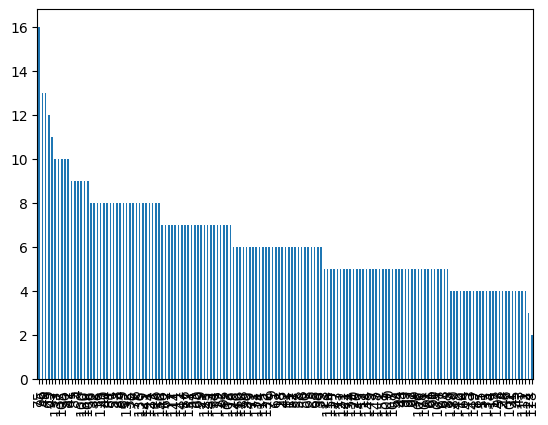

In [ ]:
# 레이블별 갯수 그래프화
df['label'].value_counts().plot(kind='bar')

## 2. 문장 토큰화 및 정수 인코딩

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.9 MB/s eta 0:00:00


In [ ]:
import transformers
transformers.__version__

'4.32.0'

In [ ]:
# 토크나이저 불러오기

from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')

In [ ]:
# 가짜 validation data (없으면 코드가 안돌아가서..)
test_data = pd.DataFrame({"label":[1, 2, 3, 4], "content":["z", "d", "d", "f"]})
test_data

,label,content
0,1,z
1,2,d
2,3,d
3,4,f


In [ ]:
# 학습용 자료 준비 (validation용 데이터는 없으면 코드가 안돌아가서 그냥 가짜로 만듦)
X_train_list = df['content'].tolist()
y_train = df['label'].tolist()
X_test_list = test_data['content'].tolist()
y_test = test_data['label'].tolist()

In [ ]:
# 문장들을 토큰화 및 패딩
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
# attention mask 확인
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3. 데이터셋 생성 및 모델 학습

In [ ]:
# 컨텐츠/레이블로 구성된 데이터셋 준비

train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(X_train), y_train)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(X_test), y_test)
)

In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 모델 준비
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=153, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 옵티마이저 준비
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5)

In [ ]:
## TPU 활용을 위해 strategy.scope 내에서 모델 선언 및 컴파일하기
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=153, from_pt=True)
  model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# callback_earlystop = EarlyStopping(
#     monitor="accuracy",      # val_accuracy 값의 개선이
#     patience=2,             # 2 epoch에 걸쳐 이뤄지지 않는 경우 학습을 조기 종료시킨다.
#     min_delta=0.001         # 0.001 이상 변화하지 않으면 개선되지 않는 것으로 봄
#     )

model.fit(
    train_dataset.shuffle(10000).batch(32), epochs=10, batch_size=32,
    validation_data = val_dataset.shuffle(10000).batch(1)
)

Epoch 1/10
31/31 [==============================] - 4s 143ms/step - loss: 1.4196 - accuracy: 0.9823 - val_loss: 4.2001 - val_accuracy: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 4s 126ms/step - loss: 1.1299 - accuracy: 0.9855 - val_loss: 4.1217 - val_accuracy: 0.0000e+00
Epoch 3/10
31/31 [==============================] - 4s 132ms/step - loss: 0.9074 - accuracy: 0.9917 - val_loss: 4.1145 - val_accuracy: 0.0000e+00
Epoch 4/10
31/31 [==============================] - 4s 127ms/step - loss: 0.7155 - accuracy: 0.9917 - val_loss: 4.0158 - val_accuracy: 0.0000e+00
Epoch 5/10
31/31 [==============================] - 4s 116ms/step - loss: 0.5692 - accuracy: 0.9917 - val_loss: 3.9592 - val_accuracy: 0.0000e+00
Epoch 6/10
31/31 [==============================] - 4s 120ms/step - loss: 0.4683 - accuracy: 0.9875 - val_loss: 3.9583 - val_accuracy: 0.0000e+00
Epoch 7/10
31/31 [==============================] - 4s 136ms/step - loss: 0.3798 - accuracy: 0.9927 - val_loss: 3.9378 - val

## 4. 모델 저장

In [ ]:
# 모델 저장
model.save_pretrained('sw_model/bert-base')
tokenizer.save_pretrained('sw_model/bert-base')

('sw_model/bert-base/tokenizer_config.json',
 'sw_model/bert-base/special_tokens_map.json',
 'sw_model/bert-base/vocab.txt',
 'sw_model/bert-base/added_tokens.json',
 'sw_model/bert-base/tokenizer.json')

In [ ]:
# 모델 불러오기

from transformers import TextClassificationPipeline


# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained('sw_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('sw_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework='tf',
    return_all_scores=True)

Some layers from the model checkpoint at sw_model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at sw_model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_class

## 5. 모델 불러오기 및 테스트

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification

# 모델 불러오기
loaded_tokenizer = BertTokenizerFast.from_pretrained('sw_model/bert-base') # 여기 모델 주소 입력
loaded_model = TFBertForSequenceClassification.from_pretrained('sw_model/bert-base') # 여기 모델 주소 입력

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework='tf',
    return_all_scores=True)

Some layers from the model checkpoint at sw_model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at sw_model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# 레이블-메뉴 데이터 오픈
label_menu = pd.read_csv("/content/drive/MyDrive/음식 추천 프로젝트/label-menu.csv")
label_menu

,label,menu
0,0,갈비찜
1,1,갈비탕
2,2,감바스
3,3,감자전
4,4,감자탕
...,...,...
148,148,호떡
149,149,홍합탕
150,150,회
151,151,회덮밥


In [ ]:
input_sentence = "졸업식날 먹기 좋은 음식 추천좀"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

115    짜장면
Name: menu, dtype: object

In [ ]:
input_sentence = "술 마렵다"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

9    곱창구이
Name: menu, dtype: object

In [ ]:
input_sentence = "중국음식 아무거나"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

49    라조기
Name: menu, dtype: object

In [ ]:
input_sentence = "감기몸살 걸려서 몸상태가 별로야"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

113    죽
Name: menu, dtype: object

In [ ]:
input_sentence = "뭘로 해장하지"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

82    설렁탕
Name: menu, dtype: object

In [ ]:
input_sentence = "전주에서 뭐 먹지"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

134    콩나물국밥
Name: menu, dtype: object

In [ ]:
input_sentence = "소주 안주로 뭐 먹을까"

a = tf.math.argmax(pd.DataFrame(text_classifier(input_sentence)[0])['score'].tolist(), axis=-1).numpy()
label_menu[label_menu["label"]==a]["menu"]

29    닭똥집
Name: menu, dtype: object

In [ ]:
input_sentence = "애인이랑 특별한 기념일인데 뭐 먹지"

for i in pd.DataFrame(text_classifier(input_sentence)[0]).sort_values(by='score').tail(5)['label'].index:
  print(label_menu[label_menu["label"]==i]["menu"])

89    스테이크
Name: menu, dtype: object
105    육회
Name: menu, dtype: object
41    떡국
Name: menu, dtype: object
122    참치회
Name: menu, dtype: object
90    스파게티
Name: menu, dtype: object


In [ ]:
import random

list_a = []
input_sentence = "애인이랑 특별한 기념일인데 뭐 먹지"

for i in pd.DataFrame(text_classifier(input_sentence)[0]).sort_values(by='score').tail(5)['label'].index:
  list_a.append(i)

r_index = random.choice(list_a)
label_menu.loc[r_index,'menu']

'스테이크'